## AISE4010- Assignment2 - Time Series Forecasting using CNN, RNN, LSTM and GRU

## Grade: 100 points

### Instructions

#### Follow These Steps before submitting your assignment 

1. Complete the notebook.

2. Make sure all plots have axis labels.

3. Once the notebook is complete, `Restart` your kernel by clicking 'Kernel' > 'Restart & Run All'.

4. Fix any errors until your notebook runs without any problems.

5. Submit one completed notebook for the group to OWL by the deadline.

6. Make sure to reference all external code and documentation used.

### Dataset

The `StockData.csv` represents a time series dataset designed to simulate the behavior of stock prices over a period of 1000 days, starting from January 1, 2023. This dataset includes key features commonly found in stock market data, such as opening prices, closing prices, daily highs, daily lows, and trading volume. 

Features:
- Date: The timestamp representing the specific day for each record.
- Open: The stock's price at the start of the trading day. 
- High: The highest price of the stock during the trading day. It is generally higher than the opening price, reflecting intraday market movements.
- Low: The lowest price of the stock during the trading day. It is usually lower than the opening price, capturing downward movements in the market.
- Close: The stock’s price at the end of the trading day. This price reflects the market's closing valuation and fluctuates within a range close to the opening price.
- Volume: The number of shares traded during the day.

### Question 1 - Data Preprocessing (15%)
- Q1.1 Load the provided dataset and plot the `Closing prices` time series. (5%)
- Q1.2 (5%): 

  - a) Decompose the time series into its components and explain them.  
  - b) What do the trend and seasonality components tell you about the overall behavior of the time series? How does understanding     these components help in selecting a model for time series forecasting?
- Q1.3 Restructure the time series using a sliding window approach (with size 10) to prepare it for supervised learning. Split the `Closing prices` time series into 80% for training and 20% for testing. (5%)


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from numpy import array

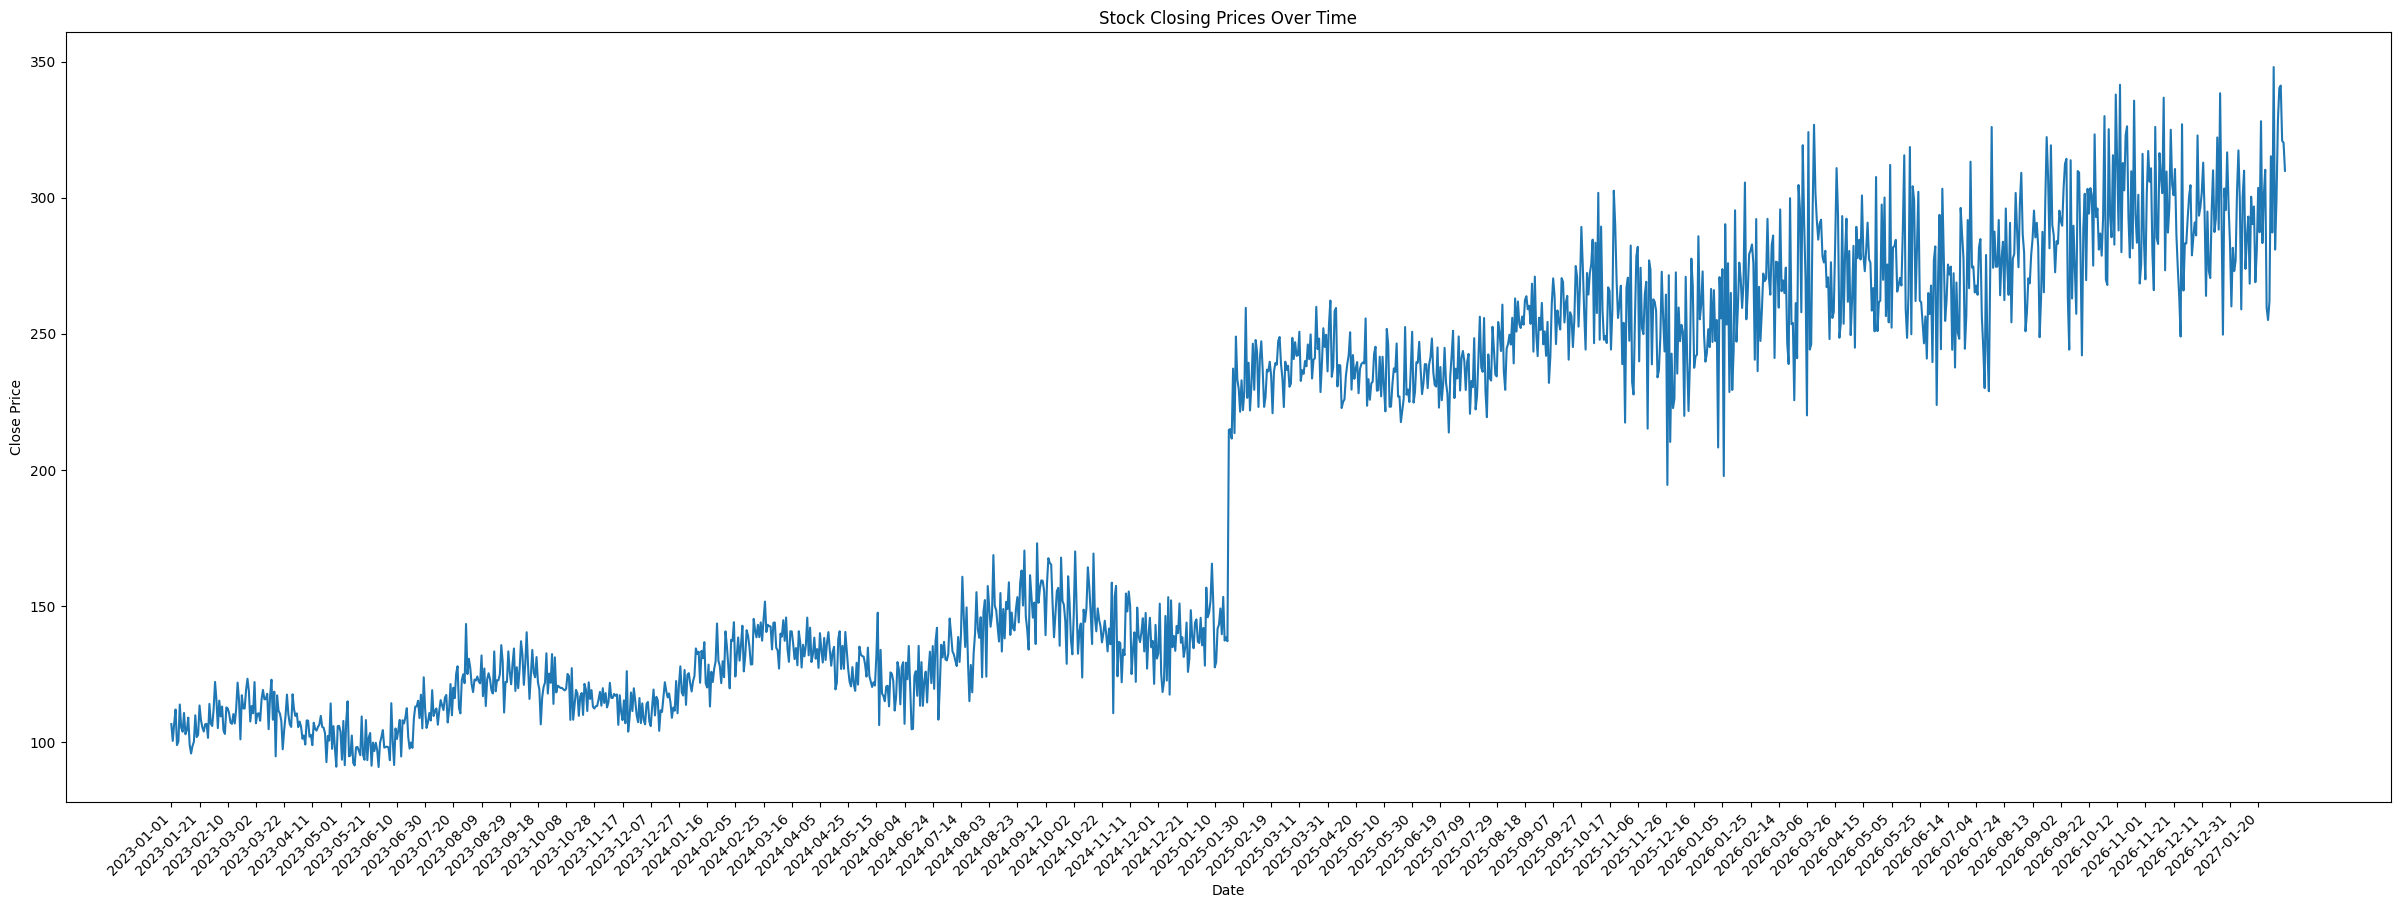

'According to this plot, it appears to be a time series data with a clear upward trend and some seasonality. The upward trend suggests that the closing price of the stock is generally increasing over time. The data is non-stationary'

In [2]:
# Q1.1 
# Load the dataset
df = pd.read_csv('StockData.csv')
# print(df.shape)

x_series = df['Date']
y_series = df['Close']

plt.figure(figsize=(30,10))
plt.plot(y_series)
plt.xticks(rotation=45, ha='right')
plt.xticks(ticks=range(0, len(x_series), 20), labels=x_series[::20], rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Closing Prices Over Time')
plt.show()

'''According to this plot, it appears to be a time series data with a clear upward trend and some seasonality. The upward trend suggests that the closing price of the stock is generally increasing over time. The data is non-stationary'''

In [3]:
# Q1.3
def split_sequence(sequence, n_steps):  # a function that splits a sequence into input-output pairs based on a specified step size
    X, y = list(), list()   # initialize empty lists to hold input (X) and output (y) sequences
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps # calculate the ending index for the current input sequence
        
        # check if we are beyond the sequence, stop the loop if we are beyond the sequence length 
        if end_ix > len(sequence)-1:
            break
        
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix] # Define input-output pair based on current index
        X.append(seq_x) # append input sequence (seq_x) to the X list
        y.append(seq_y) # append output sequence (seq_y) to the y list
        
    return array(X), array(y)   # convert lists to arrays and return input-output arrays


n_steps = 10 # sliding window of 10
X, y = split_sequence(y_series, n_steps)


# Split into training and testing (80% train, 20% test)
train_size = int(0.8 * len(X))

# Split the data
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 1192, Testing samples: 298


*Write your Answer to Q1.2-b here:*

The trend shows the long-term direction of the data. In this case, the trend is upward, indicating that the closing price of the stock is generally increasing over time and that the closing stocks are generally appreciating, which is generally considered good for investors. The closing prices also fluctuate about every 5-6 months, which indicates some seasonality. This seasonality suggests that there are recurring patterns in the data that may be too complex for some models to capture. Data with little seasonality may be better suited for simpler models like ARIMA, where large computational power isn't needed. On the other hand, data with more seasonality may require more complex models like LSTM that will capture seasonality and trend effectively, but will however come at the cost of more computational power. 

### Question2 - 1D Convolutional Neural Network (CNN) (20%)
- Q2.1 Create a 1D CNN model for time series forecasting. The model should have two convolutional layers of size 64 and 32 and kernel size of 3, fully connected layer of size 50, droup out of 0.3, and ReLU activation. Train the model using the provided dataset for 50 epochs. Use the batch_size of 32, and ADAM optimizer. Plot the training loss and validation loss. (12%)
- Q2.2 Evaluate the model's performance using RMSE and MAE on the test set. Plot the predicted values alongside the actual values to visualize how well the model is forecasting the time series. (6%)
- Q2.3 How does the 1D-CNN perform in terms of capturing short-term dependencies? Based on the RMSE and MAE values, do you think this model can effectively capture long-term trends? Why or why not? (2%)


In [4]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import GRU
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Concatenate
import keras
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# set seed to reproduce similar results
np.random.seed(0)

In [5]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# (number of samples, number of time steps, number of features)
# a 3D array that has the number of samples, 10 time steps, and 1 feature (the closing price)

print(X_train.shape)

(1192, 10, 1)


In [6]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], 1 # 10 time steps, 1 feature, 1 output (the closing price)

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.3))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding = 'same'))
model.add(Dropout(0.3))
# model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_outputs))

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=50, 
                    batch_size=32)

C:\Users\edmun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 7553.1328 - val_loss: 1873.9663
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 716.9135 - val_loss: 580.2902
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 528.7103 - val_loss: 1583.6884
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 505.5026 - val_loss: 865.5444
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 442.3922 - val_loss: 1036.3271
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 409.0628 - val_loss: 890.3324
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 374.2181 - val_loss: 1321.4570
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 348.8391 - val_loss: 931.6016
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 278.4751 - val_loss: 1090.0688
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 298.9873 - val_loss: 1955.1272
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 265.5544 - val_loss: 1340.8157
Epoch 12/50
30/30 ━━━━

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# RMSE and MAE on the test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse}, MAE: {mae}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RMSE: 63.34694050046516, MAE: 59.68184856884525


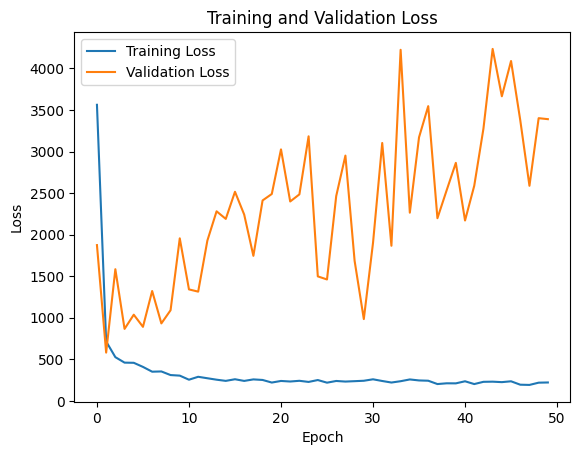

In [8]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

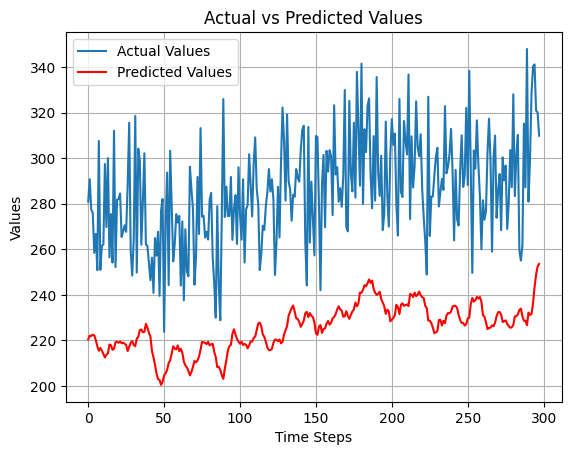

In [9]:
plt.plot(y_test, label='Actual Values')  
plt.plot(y_pred, label='Predicted Values', color='red')  
plt.xlabel('Time Steps')  
plt.ylabel('Values')      
plt.title('Actual vs Predicted Values')  
plt.legend()  
plt.grid() 
plt.show()   

*Write your Answer to Q2.3 Here:*

The model attempts to capture the seasonality, however it doesn't perform well in capturing long-term trends. The RMSE and MAE values are relatively high, indicating that the model's predictions deviate significantly from the actual values. This suggests that the model may not be effective in capturing long-term trends in the time series data. The 1D-CNN model is designed to capture short-term dependencies and patterns, and it performs well in this aspect. However, for data with strong long-term trends, other models like LSTM or GRU might be more suitable.

### Question 3 - Recurrent Neural Networks (RNN) (20%)
- Q3.1 Create an RNN model for time series forecasting. The model should include a SimpleRNN layer of size 40 and ReLU activation. Train the model using the provided dataset for 50 epochs. Use the batch_size of 16, and ADAM optimizer. Plot the training loss and validation loss. (12%)
- Q3.2 Evaluate the model's performance using RMSE and MAE on the test set. Plot the predicted values alongside the actual values to visualize how well the model is forecasting the time series. (6%)
- Q3.3 Why did we use a smaller batch size compared to CNN model. Why might RNN struggle with long-term dependencies, and how is this reflected in the evaluation metrics? (2%)


In [10]:
model = Sequential()
model.add(SimpleRNN(40, activation='relu', input_shape=(n_timesteps, n_features)))  
model.add(Dense(n_outputs))  

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=50, 
                    batch_size=16)

Epoch 1/50


C:\Users\edmun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1124.7435 - val_loss: 490.2183
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 97.1449 - val_loss: 482.7550
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106.8743 - val_loss: 467.9778
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 109.3800 - val_loss: 471.6798
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 95.4750 - val_loss: 470.1786
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 99.9585 - val_loss: 490.7904
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 96.9260 - val_loss: 509.6959
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 114.4292 - val_loss: 468.7100
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 109.0761 - val_loss: 470.6588
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 99.9868 - val_loss: 479.4735
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 93.7063 - val_loss: 559.8906
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
RMSE: 22.109141535853524, MAE: 18.00144814351401


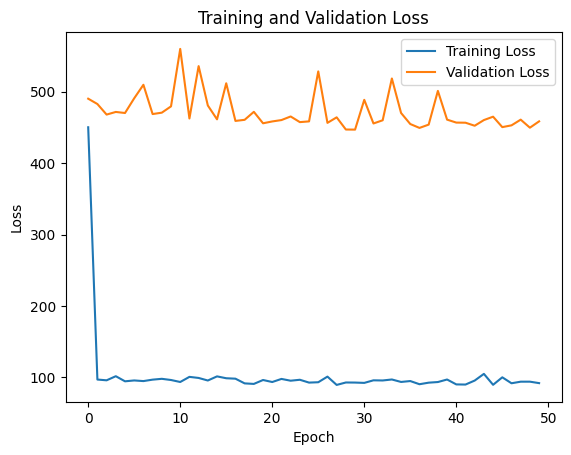

In [11]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse}, MAE: {mae}")

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

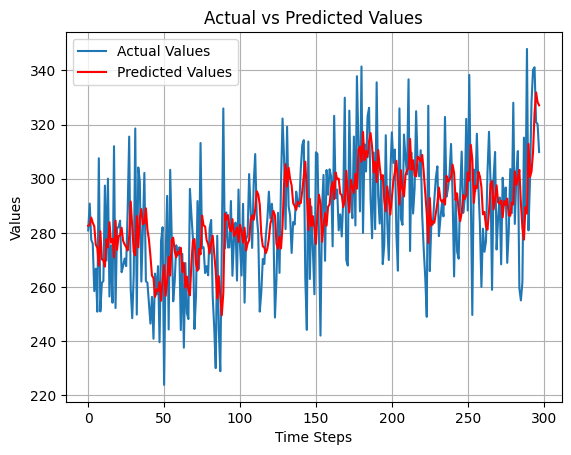

In [12]:
plt.plot(y_test, label='Actual Values')  
plt.plot(y_pred, label='Predicted Values', color='red')  
plt.xlabel('Time Steps')  
plt.ylabel('Values')      
plt.title('Actual vs Predicted Values')  
plt.legend()  
plt.grid() 
plt.show()   

*Write your Answer to Q3.3 Here:*

RNNs use a smaller batch size compared to CNN models because RNNs process data sequentially, and smaller batch sizes can help in reducing the computational complexity and memory requirements. Additionally, using smaller batch sizes can introduce more noise in the training process, which can help in preventing overfitting.

### Question 4 - Long Short-Term Memory (LSTM) (20%)
- Q4.1 Create an LSTM model for time series forecasting.The model should include two LSTM layers of size 100 and 50, and ReLU activation. Train the model using the provided dataset for 100 epochs. Use the batch_size of 16, and ADAM optimizer. Plot the training loss and validation loss. (12%)
- Q4.2 Evaluate the model's performance using RMSE and MAE on the test set. Plot the predicted values alongside the actual values to visualize how well the model is forecasting the time series. (6%)
- Q4.3 Why do we use a larger epoch compared to RNN? (2%)

In [13]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(LSTM(50, activation='relu'))

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs))
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=100, 
                    batch_size=16)

Epoch 1/100


C:\Users\edmun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 5959.1514 - val_loss: 422.9708
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 136.4566 - val_loss: 422.6511
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 103.0379 - val_loss: 459.0949
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 131.8066 - val_loss: 417.7130
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 145.4853 - val_loss: 423.7494
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 99.6109 - val_loss: 517.4171
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 134.1840 - val_loss: 497.2955
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 132.8137 - val_loss: 427.0112
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 114.6099 - val_loss: 415.0054
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 115.0112 - val_loss: 473.3539
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 142.1557 - val_loss: 414.4517
Epoch 12/100
60/60 ━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
RMSE: 21.869878926739812, MAE: 17.615147488273063


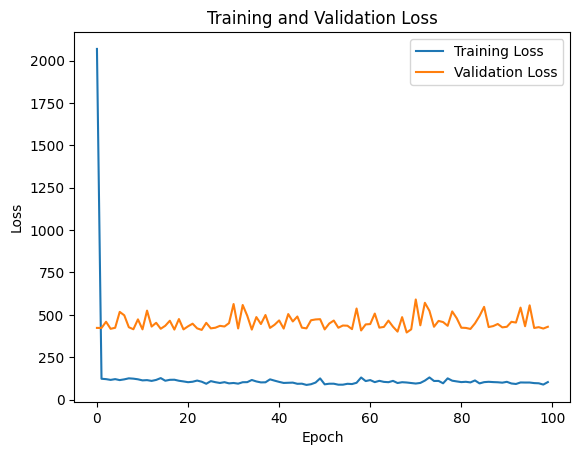

In [14]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse}, MAE: {mae}")

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

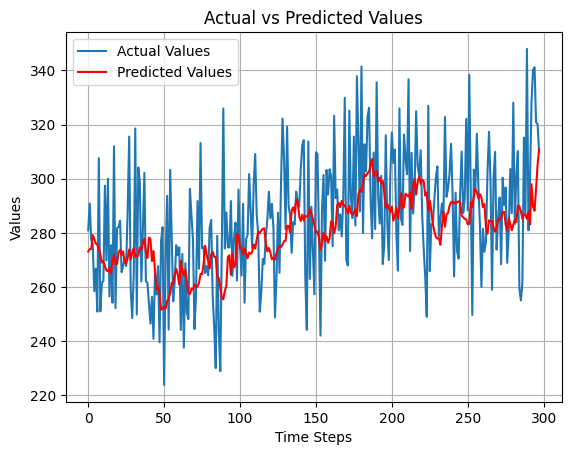

In [15]:
plt.plot(y_test, label='Actual Values')  
plt.plot(y_pred, label='Predicted Values', color='red')  
plt.xlabel('Time Steps')  
plt.ylabel('Values')      
plt.title('Actual vs Predicted Values')  
plt.legend()  
plt.grid() 
plt.show()   

*Write your Answer to Q4.3 Here:*
LSTMs use a larger number of epochs compared to RNNs because LSTMs have a more complex structure that allows them to capture longer-term dependencies in the data. Training for a larger number of epochs gives the LSTM model more opportunities to learn these dependencies and improve its forecasting performance.

### Question 5 - Gated Recurrent Unit (GRU) (20%)
- Q5.1 Create a GRU model for time series forecasting.The model should include two GRU layers of size 80 and 40, and ReLU activation. Train the model using the provided dataset for 100 epochs. Use the batch_size of 16, and ADAM optimizer. Plot the training loss and validation loss. (12%)
- Q5.2 Evaluate the model's performance using RMSE and MAE on the test set. Plot the predicted values alongside the actual values to visualize how well the model is forecasting the time series.(6%)
- Q5.3 How does the GRU compare to LSTM in terms of computational efficiency and forecasting performance? (2%)

In [16]:
model = Sequential()
model.add(GRU(80, activation='relu', return_sequences=True, input_shape=(n_timesteps, n_features)))  # First GRU layer
model.add(GRU(40, activation='relu'))  # Second GRU layer
model.add(Dense(n_outputs))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=100, 
                    batch_size=16) 


C:\Users\edmun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 14590.1602 - val_loss: 442.4333
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 88.7746 - val_loss: 450.8453
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 98.8120 - val_loss: 447.8866
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 82.9406 - val_loss: 439.4527
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 95.7858 - val_loss: 437.8812
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 97.1167 - val_loss: 435.9065
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 92.0928 - val_loss: 470.9570
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 86.9635 - val_loss: 439.5040
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 110.0518 - val_loss: 465.2447
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 101.5141 - val_loss: 441.1218
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 98.3964 - val_loss: 443.3347
Epoch 12/100
60/60 

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step
RMSE: 22.18034297641902, MAE: 18.0650274296934


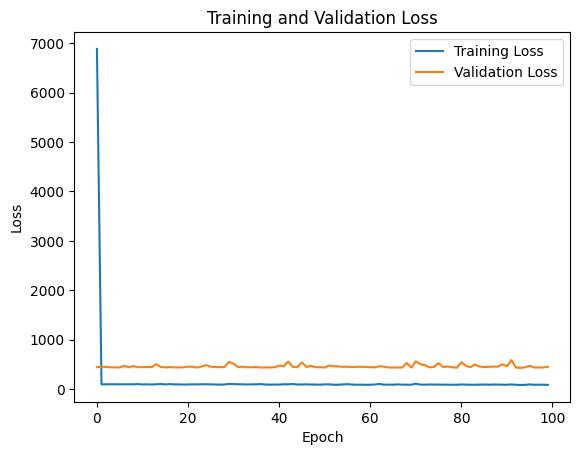

In [17]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse}, MAE: {mae}")

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

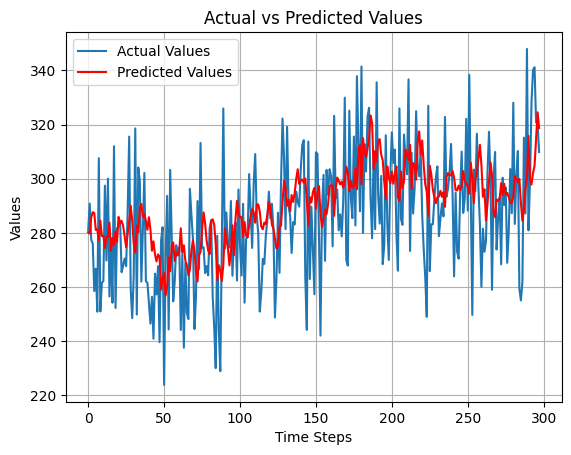

In [18]:
plt.plot(y_test, label='Actual Values')  
plt.plot(y_pred, label='Predicted Values', color='red')  
plt.xlabel('Time Steps')  
plt.ylabel('Values')      
plt.title('Actual vs Predicted Values')  
plt.legend()  
plt.grid() 
plt.show()   

*Write your Answer to Q5.3 Here:*

### Question 6 - Discussion (5%)
- Q6.1 Compare the performance of 1D-CNN, RNN, LSTM, and GRU models based on training and test execution time, performance (RMSE and MAE), and potential overfitting/underfitting. (3%)
- Q6.2 Discuss in which cases you would prefer using 1D-CNN vs LSTM or GRU for time series data. (2%)


*Write your Answer to Q6.2 Here:*